## Setup

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, MultiPolygon
from geopy.distance import geodesic

from timezonefinder import TimezoneFinder
from datetime import datetime
import pytz

In [ ]:
# Load the dataset
df_raw = pd.read_csv('ais_disabling_events.csv')

# Display the first few rows of the dataset
df_raw.head()

### Data Cleaning

In [28]:
df_prep = df_raw.copy()

# create new col 'gap_dist_nmi' in df_prep with geodesic distance in nautical miles
# from 'gap_start_lon' and 'gap_start_lat' to 'gap_end_lon' and 'gap_end_lat'
df_prep['gap_dist_nmi'] = df_prep.apply(lambda x: geodesic((x['gap_start_lat'], x['gap_start_lon']), (x['gap_end_lat'], x['gap_end_lon'])).nm, axis=1)

# remove irrelavent countries ('flags') e.g. Kosovo
df_prep = df_prep[~df_prep['flag'].isin(['XXK'])]

# merge all territory flags in df_sampled['flag'] to their main country (e.g. FRA)
df_prep['flag'] = df_prep['flag'].replace('REU', 'FRA') # Reunion
df_prep['flag'] = df_prep['flag'].replace('CXR', 'AUS') # Christmas Island
df_prep['flag'] = df_prep['flag'].replace('UNK', 'KOS') # match UNK vessels to Kosovo

# drop rows with empty 'flag' values
df_prep = df_prep.dropna(subset=['flag'])

# turn gap_start_timestamp and gap_end_timestamp from str to datetime
df_prep['gap_start_timestamp'] = pd.to_datetime(df_prep['gap_start_timestamp'])
df_prep['gap_end_timestamp'] = pd.to_datetime(df_prep['gap_end_timestamp'])

# keep rows where 'flag' repeats at least 50 times
# print(df_prep.shape, df_prep['flag'].nunique())
df_prep = df_prep.groupby('flag').filter(lambda x: len(x) >= 50)
# print(df_prep.shape, df_prep['flag'].nunique())

(54666, 16) 99
(54152, 16) 50


## Global outlook - dashboard 1

### Timezone & Day vs Night

In [5]:
from timezonefinder import TimezoneFinder
from datetime import datetime
import pandas as pd
import pytz

# Create an instance of TimezoneFinder
tf = TimezoneFinder()

# Define function to get timezone
def get_timezone(row):
    return tf.timezone_at(lng=row['gap_start_lon'], lat=row['gap_start_lat']) # note the lng (longitude) comes first

# Define function to get local time
def get_local_time(row):
    utc_time = row['gap_start_timestamp']
    timezone_str = row['start_timezone']
    timezone = pytz.timezone(timezone_str)

    return utc_time.replace(tzinfo=pytz.utc).astimezone(timezone)

# Apply the functions
df_prep['start_timezone'] = df_prep.apply(get_timezone, axis=1)
# df_prep['start_localtime'] = df_prep.apply(get_local_time, axis=1)


In [6]:
from datetime import timedelta
from astral.sun import sun
from astral import LocationInfo
import pandas as pd


def generate_sun_times(row):
    # Create an astral Location object for the start location
    loc = LocationInfo("", "", "", row['gap_start_lat'], row['gap_start_lon'])
    
    # Convert the gap timestamps to the start timezone
    start_time = row['gap_start_timestamp'].astimezone(row['start_timezone'])
    end_time = row['gap_end_timestamp'].astimezone(row['start_timezone'])
    
    current_date = start_time.date()
    
    sun_times = []
    
    while current_date <= end_time.date():
        temp_list = []  # A temporary list to hold sun-related events for the current date
        try:
            s = sun(loc.observer, date=current_date)
            # Ensure sunrise and sunset are within the gap timestamps and add them to temp_list
            if start_time <= s['sunrise'] <= end_time:
                temp_list.append(('sunrise', s['sunrise']))
            if start_time <= s['sunset'] <= end_time:
                temp_list.append(('sunset', s['sunset']))    
            # Sort temp_list based on the time and append the sorted elements to sun_times
            # So that events are in chronological order
            temp_list.sort(key=lambda x: x[1])
            sun_times.extend(temp_list)

        except Exception as e:
            polar_type = None
            if "Sun never reaches" in str(e):
                polar_type = 'Polar Day'
            elif "Sun is always below" in str(e):
                polar_type = 'Polar Night'
            else:
                polar_type = 'Error'
            
            # Only append the polar_type if it's different from the last element in sun_times
            # i.e. don't append if the last element is the same polar type
            # result is no consecutive polar days or polar nights
            # Also, only append if polar_type is not 'Error'
            if (not sun_times or sun_times[-1][1] != polar_type) and polar_type != 'Error':
                sun_times.append(('polar_phenomenon', polar_type))
        
        current_date += timedelta(days=1)
    
    return sun_times

# df_prep = df_prep.iloc[0:20000, :].copy()
df_prep['sun_times'] = df_prep.apply(generate_sun_times, axis=1)

### Calculate % of daytime vs nighttime

In [7]:
df_suntime = df_prep.copy()
print(df_suntime.shape)
# print index where df_suntime['sun_times'] is empty
# df_no_sun_event = df_suntime[df_suntime['sun_times'].apply(lambda x: len(x) == 0)]

# get df_suntime that is df_prep - df_no_sun_event
# df_suntime = df_suntime[~df_suntime.index.isin(df_no_sun_event.index)]
# print(df_suntime.shape)
# df_no_sun_event[df_no_sun_event['gap_hours'] == df_no_sun_event['gap_hours'].min()]

(54666, 18)


In [8]:
def calculate_day_night_duration(row):
    sun_times = row['sun_times']
    start_time = row['gap_start_timestamp'].astimezone(row['start_timezone'])
    end_time = row['gap_end_timestamp'].astimezone(row['start_timezone'])

    current_time = start_time
    total_daytime = timedelta()
    total_nighttime = timedelta()
    last_event_type = None  # keep track of the last event type
   
    # Handle case where sun_times is empty
    if not sun_times:
        try:
            loc = LocationInfo("", "", "", row['gap_start_lat'], row['gap_start_lon'])
            s = sun(loc.observer, date=start_time.date() - timedelta(days=1))
            # print(s)
            if s['sunrise'] < start_time and s['sunset'] > start_time:
                last_event_type = 'sunrise'
            else:
                last_event_type = 'sunset'
        except Exception as e:
            if "Sun never reaches" in str(e):
                last_event_type = 'Polar Day'
            elif "Sun is always below" in str(e):
                last_event_type = 'Polar Night'
            else:
                last_event_type = 'Unknown'
        # print(last_event_type)
        duration = end_time - start_time
        if last_event_type == 'sunrise' or last_event_type == 'Polar Day':
            total_daytime += duration
        elif last_event_type == 'sunset' or last_event_type == 'Polar Night':
            total_nighttime += duration
        else:  # Default to daytime
            total_daytime += duration
        
        return total_daytime, total_nighttime

    for event, event_time in sun_times:
        if event == 'sunrise':
            total_nighttime += (event_time - current_time)
            current_time = event_time
            last_event_type = 'sunrise'
            
        elif event == 'sunset':
            total_daytime += (event_time - current_time)
            current_time = event_time
            last_event_type = 'sunset'
            
        elif event == 'polar_phenomenon':
            # if the phenomenon changes (from day to night or vice versa), only then update time
            if last_event_type != event_time:
                next_event_index = sun_times.index((event, event_time)) + 1
                if next_event_index < len(sun_times) and sun_times[next_event_index][0] != 'polar_phenomenon':
                    next_event_time = sun_times[next_event_index][1]
                    duration = (next_event_time - current_time)
                else:
                    duration = (end_time - current_time)
                
                if event_time == 'Polar Day':
                    total_daytime += duration
                else:
                    total_nighttime += duration
                    
                current_time += duration
                last_event_type = event_time

    # Account for time from the last event to gap_end_timestamp
    if current_time != end_time:
        # Handle the case if the list is empty
        if sun_times:
            last_event = sun_times[-1][0]
            last_phenomenon = sun_times[-1][1] if last_event == 'polar_phenomenon' else None
        else:
            last_event = None
            last_phenomenon = None

        if last_event == 'sunset' or last_phenomenon == 'Polar Night':
            total_nighttime += (end_time - current_time)
        else:
            total_daytime += (end_time - current_time)

    return total_daytime, total_nighttime

# Apply the function and create new columns for daytime and nighttime durations
df_suntime['daytime_duration'], df_suntime['nighttime_duration'] = zip(*df_suntime.apply(calculate_day_night_duration, axis=1))

In [9]:
df_suntime.head()

,gap_id,mmsi,vessel_class,flag,vessel_length_m,vessel_tonnage_gt,gap_start_timestamp,gap_start_lat,gap_start_lon,gap_start_distance_from_shore_m,gap_end_timestamp,gap_end_lat,gap_end_lon,gap_end_distance_from_shore_m,gap_hours,gap_dist_nmi,start_timezone,sun_times,daytime_duration,nighttime_duration
1,52dcbd77bbdad9ee2642f574acf45190,150402949,other,CHN,54.994278,904.204044,2019-01-31 04:09:19+00:00,-45.895618,-60.642950,396000.0,2019-01-31 18:00:44+00:00,-45.808745,-60.654917,392000.0,13.850000,5.237832,Etc/GMT+4,"[(sunrise, 2019-01-31 08:55:22.197387+00:00)]",0 days 09:05:21.802613,0 days 04:46:03.197387
2,22b6d49ed4bb4d017884b6299ed185f4,204201370,other,PRT,15.350000,40.940000,2018-05-27 04:47:20+00:00,37.836315,-29.405573,95000.0,2018-05-28 14:32:01+00:00,37.860093,-29.286443,87000.0,33.733333,5.838056,Etc/GMT+2,"[(sunrise, 2018-05-27 06:39:45.209071+00:00), ...",0 days 22:23:13.924525,0 days 11:21:27.075475
3,1abe463d7f61b110c44f1d1b4654a213,204206740,other,PRT,20.000000,77.263333,2019-06-21 12:17:01+00:00,32.190453,-18.031552,98000.0,2019-06-22 18:56:01+00:00,32.119552,-18.123323,109000.0,30.650000,6.314532,Etc/GMT+1,"[(sunset, 2019-06-21 20:21:31.343047+00:00), (...",0 days 20:54:03.957737,0 days 09:44:56.042263
4,72d047a15e33f67c3c5b91c78ff612be,204209840,other,PRT,20.000000,87.435000,2017-07-02 13:13:08+00:00,39.388467,-29.215400,93000.0,2017-07-04 15:30:29+00:00,38.909333,-28.329817,17000.0,50.283333,50.334268,Etc/GMT+2,"[(sunset, 2017-07-02 21:27:13.975308+00:00), (...",1 days 08:01:01.023263,0 days 18:16:19.976737
5,87d87366d2def578701b373d1240a958,204225000,other,PRT,25.380000,154.000000,2017-12-10 20:05:37+00:00,38.722653,-30.001233,102000.0,2017-12-11 10:03:05+00:00,38.235638,-29.421588,65000.0,13.950000,39.974221,Etc/GMT+2,"[(sunrise, 2017-12-11 09:08:19.248388+00:00)]",0 days 00:54:45.751612,0 days 13:02:42.248388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55363,b77bb764b1f2a59bb33a5c6849d617c8,416005097,drifting_longlines,TWN,40.200000,327.000000,2018-07-11 01:09:02+00:00,-28.219092,-160.120093,729000.0,2018-07-11 16:12:19+00:00,-26.869358,-161.908588,658000.0,15.050000,124.978530,Etc/GMT+11,"[(sunset, 2018-07-11 03:59:32.185726+00:00)]",0 days 02:50:30.185726,0 days 12:12:46.814274
55364,c17d1c2f4e1103aa0f9f117e0a6b1cb0,416053500,drifting_longlines,TWN,55.900000,496.000000,2018-05-17 12:21:25+00:00,-39.040710,156.953980,634000.0,2018-05-18 15:07:55+00:00,-38.680773,157.475063,671000.0,26.766667,32.586509,Etc/GMT-10,"[(sunrise, 2018-05-17 20:30:42.445560+00:00), ...",0 days 09:55:27.309652,0 days 16:51:02.690348
55365,c84e6686f08d646090be9f445bfd1754,224900000,drifting_longlines,ESP,32.775000,411.308571,2019-11-25 12:48:03+00:00,-29.389027,-101.996370,754000.0,2019-11-27 05:24:46+00:00,-29.645573,-102.152453,750000.0,40.600000,17.393255,Etc/GMT+7,"[(sunset, 2019-11-26 01:28:33.848204+00:00), (...",1 days 06:23:50.080856,0 days 10:12:52.919144
55366,5123e83ada1b2c2d729a0ccd67171e41,412326895,drifting_longlines,CHN,35.500000,255.000000,2018-06-04 12:48:03+00:00,-11.700400,163.773813,170000.0,2018-06-05 07:52:55+00:00,-11.259930,164.288607,161000.0,19.066667,40.148973,Etc/GMT-11,"[(sunrise, 2018-06-04 19:19:27.973038+00:00), ...",0 days 11:27:40.894630,0 days 07:37:11.105370


### Calculate distance to home country
Sampling only 30k rows due to Power BI (heatmap) constraints 

In [10]:
# sample 30k rows from df_prep to new df
ais_data = df_suntime.sample(n=30000, random_state=42) 
# ais_data = ais_data.iloc[:1000, :] # use when testing
ais_data.head()

,gap_id,mmsi,vessel_class,flag,vessel_length_m,vessel_tonnage_gt,gap_start_timestamp,gap_start_lat,gap_start_lon,gap_start_distance_from_shore_m,gap_end_timestamp,gap_end_lat,gap_end_lon,gap_end_distance_from_shore_m,gap_hours,gap_dist_nmi,start_timezone,sun_times,daytime_duration,nighttime_duration
3589,80ad60cb0a7e40566d2df691f68a01e7,432927000,other,JPN,61.882382,1101.5,2017-05-14 13:55:03+00:00,-35.032400,44.160522,1050000.0,2017-06-20 14:00:32+00:00,-21.385300,56.716362,95000.0,888.083333,1051.472760,Etc/GMT-3,"[(sunset, 2017-05-14 14:08:47.238468+00:00), (...",15 days 08:55:46.441714,21 days 15:09:42.558286
38158,91fbd2fb0dc3b165ebb189332ac4209a,431700090,drifting_longlines,JPN,49.395000,478.0,2017-02-28 17:51:12+00:00,-8.724503,-109.048995,2029000.0,2017-03-01 11:13:48+00:00,-9.795860,-109.037945,1910000.0,17.366667,63.985718,Etc/GMT+7,"[(sunset, 2017-03-01 01:36:27.884206+00:00)]",0 days 07:45:15.884206,0 days 09:37:20.115794
3006,1a32c4935911ccd6c1b322a4f891f5f1,601189200,other,ZAF,21.825000,116.0,2018-06-06 13:12:57+00:00,-30.412377,13.262605,357000.0,2018-06-07 05:55:37+00:00,-29.564000,15.269362,150000.0,16.700000,116.236728,Etc/GMT-1,"[(sunset, 2018-06-06 16:12:55.480050+00:00)]",0 days 02:59:58.480050,0 days 13:42:41.519950
32134,da7a8de8c380aa73c190dce8e127e68a,529440000,tuna_purse_seines,KIR,65.783333,1526.0,2018-03-25 06:50:05+00:00,-2.362800,-175.750190,225000.0,2018-03-25 18:51:47+00:00,-2.619345,-176.473993,281000.0,12.016667,46.085291,Etc/GMT+12,"[(sunrise, 2018-03-25 17:46:03.318340+00:00)]",0 days 01:05:43.681660,0 days 10:55:58.318340
20596,549130d7fb8a6db387a5352b5ee5e841,412420967,squid_jigger,CHN,50.100000,611.0,2018-12-03 10:29:05+00:00,-18.833760,-79.878880,626000.0,2018-12-05 03:38:51+00:00,-18.853565,-79.916203,630000.0,41.150000,2.431502,Etc/GMT+5,"[(sunrise, 2018-12-03 10:33:46.440960+00:00), ...",1 days 02:23:10.632674,0 days 14:46:35.367326


In [31]:
# load shape files
countries_border_raw = gpd.read_file("shape_files_countries/ne_50m_admin_0_countries.shp")

# drop all columns except ADM0_A3 and geometry
countries_border = countries_border_raw[['SOVEREIGNT', 'ADM0_A3', 'geometry']].copy()
# corresponding changes in country names 
countries_border['SOVEREIGNT'] = countries_border['SOVEREIGNT'].replace('Reunion', 'France') # Reunion
countries_border['SOVEREIGNT'] = countries_border['SOVEREIGNT'].replace('Christmas Island', 'Australia') # Christmas Island
# countries_border['SOVEREIGNT'] = countries_border['SOVEREIGNT'].replace('UNK', 'KOS') # match UNK vessels to Kosovo
# countries_border['SOVEREIGNT'].isin(['Reunion', 'Christmas Island']).sum()

In [13]:
# apply Douglas-Peucker simiplification algorithm to reduce the number of points
tolerance = 0.5 # adjustable
countries_border['geometry'] = countries_border['geometry'].simplify(tolerance, preserve_topology=True)

# left join ais_data with selected_countries
ais_border = ais_data.merge(countries_border, left_on='flag', right_on='ADM0_A3', how='left')


In [14]:
countries_border[countries_border['SOVEREIGNT'] == 'Kosovo']

,SOVEREIGNT,ADM0_A3,geometry
130,Kosovo,KOS,"POLYGON ((20.34434 42.82793, 20.80059 43.26108..."


In [15]:
# ais_border[ais_border['geometry'].isnull()]

In [16]:
# define func to calculate min distance from ship coord to home country coast
def min_distance_to_geom(point, geom):
    """
    Calculate the minimum geodesic distance from a point to any vertex in a geometry (polygon/multipolygon).
    """
    if geom.geom_type == 'Polygon':
        coords = [(lat, lon) for (lon, lat) in geom.exterior.coords]
    elif geom.geom_type == 'MultiPolygon':
        coords = [(lat, lon) for poly in geom.geoms for (lon, lat) in poly.exterior.coords]
    else:
        coords = []
    
    # Use geopy's geodesic to calculate distances
    distances = [geodesic(point, coord).nm for coord in coords]

    # print(distances)
    
    return min(distances) if distances else float('inf')

In [17]:
# Apply the function to compute the minimum distance for each row
def compute_distance(row):
    print(f"Processing row {row.name}")
    return min_distance_to_geom((row['gap_start_lat'], row['gap_start_lon']), row['geometry'])

ais_border['dist_from_home_nmi'] = ais_border.apply(compute_distance, axis=1)
ais_border

Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Processing row 8
Processing row 9
Processing row 10
Processing row 11
Processing row 12
Processing row 13
Processing row 14
Processing row 15
Processing row 16
Processing row 17
Processing row 18
Processing row 19
Processing row 20
Processing row 21
Processing row 22
Processing row 23
Processing row 24
Processing row 25
Processing row 26
Processing row 27
Processing row 28
Processing row 29
Processing row 30
Processing row 31
Processing row 32
Processing row 33
Processing row 34
Processing row 35
Processing row 36
Processing row 37
Processing row 38
Processing row 39
Processing row 40
Processing row 41
Processing row 42
Processing row 43
Processing row 44
Processing row 45
Processing row 46
Processing row 47
Processing row 48
Processing row 49
Processing row 50
Processing row 51
Processing row 52
Processing row 53
Processing row 54
Processing row 55
Pr

,gap_id,mmsi,vessel_class,flag,vessel_length_m,vessel_tonnage_gt,gap_start_timestamp,gap_start_lat,gap_start_lon,gap_start_distance_from_shore_m,...,gap_hours,gap_dist_nmi,start_timezone,sun_times,daytime_duration,nighttime_duration,SOVEREIGNT,ADM0_A3,geometry,dist_from_home_nmi
0,80ad60cb0a7e40566d2df691f68a01e7,432927000,other,JPN,61.882382,1101.500000,2017-05-14 13:55:03+00:00,-35.032400,44.160522,1050000.0,...,888.083333,1051.472760,Etc/GMT-3,"[(sunset, 2017-05-14 14:08:47.238468+00:00), (...",15 days 08:55:46.441714,21 days 15:09:42.558286,Japan,JPN,"MULTIPOLYGON (((133.37051 36.20386, 133.23926 ...",5744.203965
1,91fbd2fb0dc3b165ebb189332ac4209a,431700090,drifting_longlines,JPN,49.395000,478.000000,2017-02-28 17:51:12+00:00,-8.724503,-109.048995,2029000.0,...,17.366667,63.985718,Etc/GMT+7,"[(sunset, 2017-03-01 01:36:27.884206+00:00)]",0 days 07:45:15.884206,0 days 09:37:20.115794,Japan,JPN,"MULTIPOLYGON (((133.37051 36.20386, 133.23926 ...",6422.278978
2,1a32c4935911ccd6c1b322a4f891f5f1,601189200,other,ZAF,21.825000,116.000000,2018-06-06 13:12:57+00:00,-30.412377,13.262605,357000.0,...,16.700000,116.236728,Etc/GMT-1,"[(sunset, 2018-06-06 16:12:55.480050+00:00)]",0 days 02:59:58.480050,0 days 13:42:41.519950,South Africa,ZAF,"MULTIPOLYGON (((29.36484 -22.19395, 31.28789 -...",198.324452
3,da7a8de8c380aa73c190dce8e127e68a,529440000,tuna_purse_seines,KIR,65.783333,1526.000000,2018-03-25 06:50:05+00:00,-2.362800,-175.750190,225000.0,...,12.016667,46.085291,Etc/GMT+12,"[(sunrise, 2018-03-25 17:46:03.318340+00:00)]",0 days 01:05:43.681660,0 days 10:55:58.318340,Kiribati,KIR,"MULTIPOLYGON (((172.96963 3.12920, 172.90625 3...",155.025783
4,549130d7fb8a6db387a5352b5ee5e841,412420967,squid_jigger,CHN,50.100000,611.000000,2018-12-03 10:29:05+00:00,-18.833760,-79.878880,626000.0,...,41.150000,2.431502,Etc/GMT+5,"[(sunrise, 2018-12-03 10:33:46.440960+00:00), ...",1 days 02:23:10.632674,0 days 14:46:35.367326,China,CHN,"MULTIPOLYGON (((118.18301 24.49629, 118.14951 ...",8373.279628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,12f015fea86d964fc0a3899fe57b96c5,224567000,trawlers,ESP,61.600000,562.800000,2017-10-04 00:37:07+00:00,-46.186453,-60.800480,393000.0,...,82.283333,37.029481,Etc/GMT+4,"[(sunrise, 2017-10-04 09:28:31.894828+00:00), ...",1 days 16:03:25.460043,1 days 18:13:34.539957,Spain,ESP,"MULTIPOLYGON (((1.59395 38.67207, 1.40576 38.6...",4992.607036
29996,4e83da54bbf13cfe60cb93ff2117a631,332001000,tuna_purse_seines,GTM,79.800000,2088.500000,2017-05-17 21:03:47+00:00,-0.413333,2.556283,356000.0,...,39.083333,410.996018,Etc/GMT,"[(sunrise, 2017-05-18 05:43:27.050353+00:00), ...",0 days 18:31:20.743970,0 days 20:34:10.256030,Guatemala,GTM,"POLYGON ((-92.23516 14.54541, -91.73657 16.070...",5461.106584
29997,dc5fed58d7e7c79cf8e6dc9d2b9d21f1,367460660,other,USA,37.911500,393.666481,2017-06-26 18:55:11+00:00,56.172652,-167.643727,123000.0,...,20.566667,139.694536,Etc/GMT+11,"[(sunset, 2017-06-27 08:01:50.850249+00:00), (...",0 days 14:10:53.601698,0 days 06:23:47.398302,United States of America,USA,"MULTIPOLYGON (((-132.74687 56.52568, -132.9480...",66.104586
29998,4259ccdbdfdeff4f5bd30b7214adcfef,431005544,squid_jigger,JPN,37.025429,171.000000,2017-06-20 08:53:09+00:00,39.592535,-177.494187,1243000.0,...,14.250000,30.722155,Etc/GMT+12,"[(sunrise, 2017-06-20 16:22:48.718011+00:00)]",0 days 06:45:58.281989,0 days 07:29:39.718011,Japan,JPN,"MULTIPOLYGON (((133.37051 36.20386, 133.23926 ...",1655.675574


### Add corresponding continents for visualization purposes

In [18]:
# load 'continent_to_country_mapping.csv' 
continent_to_country_mapping = pd.read_csv('continent_to_country_mapping.csv')


In [19]:
ais_border['flag'].isna().sum()
# continent_to_country_mapping['ISO3_Code']

0

In [20]:
# left join ais_border with continent_to_country_mapping on flag and ISO3
ais_border_continent = pd.merge(ais_border, continent_to_country_mapping[['ISO3_Code', 'Continent']], how='left', left_on='flag', right_on='ISO3_Code')
ais_border_continent.drop(columns=['ISO3_Code'], inplace=True)
# ais_border_continent[ais_border_continent['Continent'].isna()]['flag'].unique()
ais_border_continent

,gap_id,mmsi,vessel_class,flag,vessel_length_m,vessel_tonnage_gt,gap_start_timestamp,gap_start_lat,gap_start_lon,gap_start_distance_from_shore_m,...,gap_dist_nmi,start_timezone,sun_times,daytime_duration,nighttime_duration,SOVEREIGNT,ADM0_A3,geometry,dist_from_home_nmi,Continent
0,80ad60cb0a7e40566d2df691f68a01e7,432927000,other,JPN,61.882382,1101.500000,2017-05-14 13:55:03+00:00,-35.032400,44.160522,1050000.0,...,1051.472760,Etc/GMT-3,"[(sunset, 2017-05-14 14:08:47.238468+00:00), (...",15 days 08:55:46.441714,21 days 15:09:42.558286,Japan,JPN,"MULTIPOLYGON (((133.37051 36.20386, 133.23926 ...",5744.203965,Asia
1,91fbd2fb0dc3b165ebb189332ac4209a,431700090,drifting_longlines,JPN,49.395000,478.000000,2017-02-28 17:51:12+00:00,-8.724503,-109.048995,2029000.0,...,63.985718,Etc/GMT+7,"[(sunset, 2017-03-01 01:36:27.884206+00:00)]",0 days 07:45:15.884206,0 days 09:37:20.115794,Japan,JPN,"MULTIPOLYGON (((133.37051 36.20386, 133.23926 ...",6422.278978,Asia
2,1a32c4935911ccd6c1b322a4f891f5f1,601189200,other,ZAF,21.825000,116.000000,2018-06-06 13:12:57+00:00,-30.412377,13.262605,357000.0,...,116.236728,Etc/GMT-1,"[(sunset, 2018-06-06 16:12:55.480050+00:00)]",0 days 02:59:58.480050,0 days 13:42:41.519950,South Africa,ZAF,"MULTIPOLYGON (((29.36484 -22.19395, 31.28789 -...",198.324452,Africa
3,da7a8de8c380aa73c190dce8e127e68a,529440000,tuna_purse_seines,KIR,65.783333,1526.000000,2018-03-25 06:50:05+00:00,-2.362800,-175.750190,225000.0,...,46.085291,Etc/GMT+12,"[(sunrise, 2018-03-25 17:46:03.318340+00:00)]",0 days 01:05:43.681660,0 days 10:55:58.318340,Kiribati,KIR,"MULTIPOLYGON (((172.96963 3.12920, 172.90625 3...",155.025783,Oceania
4,549130d7fb8a6db387a5352b5ee5e841,412420967,squid_jigger,CHN,50.100000,611.000000,2018-12-03 10:29:05+00:00,-18.833760,-79.878880,626000.0,...,2.431502,Etc/GMT+5,"[(sunrise, 2018-12-03 10:33:46.440960+00:00), ...",1 days 02:23:10.632674,0 days 14:46:35.367326,China,CHN,"MULTIPOLYGON (((118.18301 24.49629, 118.14951 ...",8373.279628,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,12f015fea86d964fc0a3899fe57b96c5,224567000,trawlers,ESP,61.600000,562.800000,2017-10-04 00:37:07+00:00,-46.186453,-60.800480,393000.0,...,37.029481,Etc/GMT+4,"[(sunrise, 2017-10-04 09:28:31.894828+00:00), ...",1 days 16:03:25.460043,1 days 18:13:34.539957,Spain,ESP,"MULTIPOLYGON (((1.59395 38.67207, 1.40576 38.6...",4992.607036,Europe
29996,4e83da54bbf13cfe60cb93ff2117a631,332001000,tuna_purse_seines,GTM,79.800000,2088.500000,2017-05-17 21:03:47+00:00,-0.413333,2.556283,356000.0,...,410.996018,Etc/GMT,"[(sunrise, 2017-05-18 05:43:27.050353+00:00), ...",0 days 18:31:20.743970,0 days 20:34:10.256030,Guatemala,GTM,"POLYGON ((-92.23516 14.54541, -91.73657 16.070...",5461.106584,North America
29997,dc5fed58d7e7c79cf8e6dc9d2b9d21f1,367460660,other,USA,37.911500,393.666481,2017-06-26 18:55:11+00:00,56.172652,-167.643727,123000.0,...,139.694536,Etc/GMT+11,"[(sunset, 2017-06-27 08:01:50.850249+00:00), (...",0 days 14:10:53.601698,0 days 06:23:47.398302,United States of America,USA,"MULTIPOLYGON (((-132.74687 56.52568, -132.9480...",66.104586,North America
29998,4259ccdbdfdeff4f5bd30b7214adcfef,431005544,squid_jigger,JPN,37.025429,171.000000,2017-06-20 08:53:09+00:00,39.592535,-177.494187,1243000.0,...,30.722155,Etc/GMT+12,"[(sunrise, 2017-06-20 16:22:48.718011+00:00)]",0 days 06:45:58.281989,0 days 07:29:39.718011,Japan,JPN,"MULTIPOLYGON (((133.37051 36.20386, 133.23926 ...",1655.675574,Asia


### Additional calculations

In [21]:
ais_border_output = ais_border_continent.drop(columns=['geometry', 'ADM0_A3', 'sun_times']) # drop geometry column which messes with csv format

# create daytime_duration_m and nighttime_duration_m columns by converting daytime_duration and nighttime_duration to hours
ais_border_output['daytime_duration_h'] = ais_border_output['daytime_duration'].dt.total_seconds() / 3600
ais_border_output['nighttime_duration_h'] = ais_border_output['nighttime_duration'].dt.total_seconds() / 3600
# drop duration in datetime format
ais_border_output = ais_border_output.drop(columns=['daytime_duration', 'nighttime_duration'])


### calculate percentage of daytime by country
# First, group the data by 'flag' and sum the daytime and nighttime durations
grouped_duraion_by_country = ais_border_output.groupby('flag').agg({
    'daytime_duration_h': 'sum',
    'nighttime_duration_h': 'sum'
}).reset_index()
grouped_duraion_by_country['daytime_share'] = (grouped_duraion_by_country['daytime_duration_h'] / 
                                                (grouped_duraion_by_country['daytime_duration_h'] + 
                                                grouped_duraion_by_country['nighttime_duration_h'])) * 100
# create noise column for grouped_duraion_by_country between -1 to 1
grouped_duraion_by_country['noise'] = sp.randn(len(grouped_duraion_by_country['flag'])) * 0.3
# grouped_duraion_by_country['noise'].describe()

ais_border_output = pd.merge(ais_border_output, grouped_duraion_by_country[['flag', 'daytime_share', 'noise']], on='flag', how='left', suffixes=('', '_grouped_by_flag'))

# convert gap_start_timestamp and gap_end_timestamp to naive datetime
# which help export to excel
ais_border_output['gap_start_timestamp'] = ais_border_output['gap_start_timestamp'].dt.tz_localize(None)
ais_border_output['gap_end_timestamp'] = ais_border_output['gap_end_timestamp'].dt.tz_localize(None)
ais_border_output

C:\Users\Geran\AppData\Local\Temp\ipykernel_42960\2915270166.py:20: DeprecationWarning: scipy.randn is deprecated and will be removed in SciPy 2.0.0, use numpy.random.randn instead
  grouped_duraion_by_country['noise'] = sp.randn(len(grouped_duraion_by_country['flag'])) * 0.3


,gap_id,mmsi,vessel_class,flag,vessel_length_m,vessel_tonnage_gt,gap_start_timestamp,gap_start_lat,gap_start_lon,gap_start_distance_from_shore_m,...,gap_hours,gap_dist_nmi,start_timezone,SOVEREIGNT,dist_from_home_nmi,Continent,daytime_duration_h,nighttime_duration_h,daytime_share,noise
0,80ad60cb0a7e40566d2df691f68a01e7,432927000,other,JPN,61.882382,1101.500000,2017-05-14 13:55:03,-35.032400,44.160522,1050000.0,...,888.083333,1051.472760,Etc/GMT-3,Japan,5744.203965,Asia,368.929567,519.161822,49.725646,-0.349335
1,91fbd2fb0dc3b165ebb189332ac4209a,431700090,drifting_longlines,JPN,49.395000,478.000000,2017-02-28 17:51:12,-8.724503,-109.048995,2029000.0,...,17.366667,63.985718,Etc/GMT+7,Japan,6422.278978,Asia,7.754412,9.622254,49.725646,-0.349335
2,1a32c4935911ccd6c1b322a4f891f5f1,601189200,other,ZAF,21.825000,116.000000,2018-06-06 13:12:57,-30.412377,13.262605,357000.0,...,16.700000,116.236728,Etc/GMT-1,South Africa,198.324452,Africa,2.999578,13.711533,48.393379,0.104358
3,da7a8de8c380aa73c190dce8e127e68a,529440000,tuna_purse_seines,KIR,65.783333,1526.000000,2018-03-25 06:50:05,-2.362800,-175.750190,225000.0,...,12.016667,46.085291,Etc/GMT+12,Kiribati,155.025783,Oceania,1.095467,10.932866,50.470485,0.120033
4,549130d7fb8a6db387a5352b5ee5e841,412420967,squid_jigger,CHN,50.100000,611.000000,2018-12-03 10:29:05,-18.833760,-79.878880,626000.0,...,41.150000,2.431502,Etc/GMT+5,China,8373.279628,Asia,26.386287,14.776491,50.493390,0.235029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,12f015fea86d964fc0a3899fe57b96c5,224567000,trawlers,ESP,61.600000,562.800000,2017-10-04 00:37:07,-46.186453,-60.800480,393000.0,...,82.283333,37.029481,Etc/GMT+4,Spain,4992.607036,Europe,40.057072,42.226261,50.441777,-0.490371
29996,4e83da54bbf13cfe60cb93ff2117a631,332001000,tuna_purse_seines,GTM,79.800000,2088.500000,2017-05-17 21:03:47,-0.413333,2.556283,356000.0,...,39.083333,410.996018,Etc/GMT,Guatemala,5461.106584,North America,18.522429,20.569516,50.524669,0.211753
29997,dc5fed58d7e7c79cf8e6dc9d2b9d21f1,367460660,other,USA,37.911500,393.666481,2017-06-26 18:55:11,56.172652,-167.643727,123000.0,...,20.566667,139.694536,Etc/GMT+11,United States of America,66.104586,North America,14.181556,6.396500,51.426112,-0.216422
29998,4259ccdbdfdeff4f5bd30b7214adcfef,431005544,squid_jigger,JPN,37.025429,171.000000,2017-06-20 08:53:09,39.592535,-177.494187,1243000.0,...,14.250000,30.722155,Etc/GMT+12,Japan,1655.675574,Asia,6.766189,7.494366,49.725646,-0.349335


<Axes: >

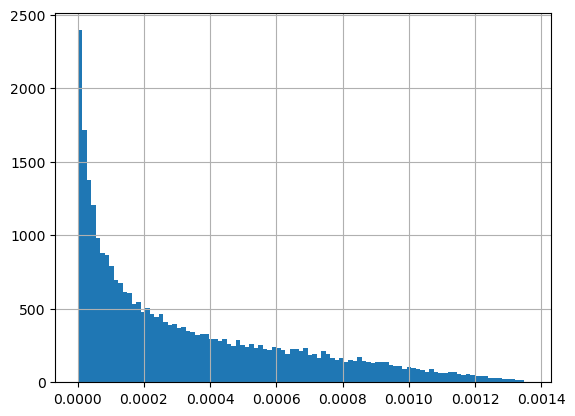

In [26]:
# check calculation error if any for calculate_day_night_duration()
ais_border_output['error'] = abs((ais_border_output['gap_hours'] - ais_border_output['daytime_duration_h'] - ais_border_output['nighttime_duration_h']) / ais_border_output['gap_hours'])
ais_border_output['error'].hist(bins=100)

### Output file as csv

In [27]:
# output ais_border_output  as excel
output_file_path = "ais_dist_border_30k_tol_50pc.xlsx"
ais_border_output.to_excel(output_file_path, index=False)
# output_file_path = "ais_dist_border_30k_tol_50pc.csv"
# ais_border_output.to_csv(output_file_path, index=False)

## Country profile - dashboard 2

### Illicit index calculations

In [13]:
# # save ais_border_continent as pickle
# ais_border_continent.to_pickle('ais_border_continent_30k_tol_50pc.pkl')

# # load ais_border_continent from pickle
# ais_border_continent = pd.read_pickle('ais_border_continent_30k_tol_50pc.pkl')

In [18]:
import numpy as np
from scipy.stats import chisquare

ais_spike = ais_border_continent.copy()


# num of countries on display
num_countries = 50

# new col gap_start_distance_from_shore_nmi from gap_start_distance_from_shore_m by dividing 1852
ais_spike['gap_start_distance_from_shore_nmi'] = ais_spike['gap_start_distance_from_shore_m'] / 1852

# calc the right # of bins for histogram
bin_count = int((round(ais_spike['gap_start_distance_from_shore_nmi'].max(), -1) - round(ais_spike['gap_start_distance_from_shore_nmi'].min(), -1)) / 25)

# gather top x countries with most observations
top_countries = ais_spike['flag'].value_counts().head(num_countries).index

# create new df from ais_spike grouped by flag and aggregate gap_id count and mmsi count
ais_spike_grouped = ais_spike.groupby('flag').agg({
    'gap_id': 'count'
}).reset_index()
# rename col gap_id to total_count
ais_spike_grouped.rename(columns={'gap_id': 'total_count'}, inplace=True)
# sort ais_spike_grouped by gap_id count descending and only keep top x countries
ais_spike_grouped = ais_spike_grouped.sort_values(by='total_count', ascending=False).head(num_countries)

ais_spike_grouped['spike_actual_narrow'] = pd.Series(dtype = 'float64')
ais_spike_grouped['spike_expected_narrow'] = pd.Series(dtype = 'float64')
ais_spike_grouped['spike_deviation_narrow'] = pd.Series(dtype = 'float64')

ais_spike_grouped['spike_actual_wide'] = pd.Series(dtype = 'float64')
ais_spike_grouped['spike_expected_wide'] = pd.Series(dtype = 'float64')
ais_spike_grouped['spike_deviation_wide'] = pd.Series(dtype = 'float64')

ais_spike_grouped['chi_square'] = pd.Series(dtype='float64')
ais_spike_grouped['p_value'] = pd.Series(dtype='float64')


for country in top_countries:
    # print divider line
    print(f"{'-' * 30}")
    print(f"Processing country {country}")
    # Filter data for the specific country
    data = ais_spike[ais_spike['flag'] == country]['gap_start_distance_from_shore_nmi'].to_numpy()

    # Create custom bins
    bin_width = 25
    min_bin = 50
    max_bin = 1200
    custom_bins = np.arange(min_bin, max_bin + bin_width, bin_width)
    
    # Actual count of ships in each bin
    hist, _ = np.histogram(data, bins=custom_bins)
    
    # Estimate the rate parameter (lambda)
    lambda_estimate = 1 / np.mean(data)

    # Generate the expected distribution for a range of distances
    cdf_values = 1 - np.exp(-lambda_estimate * custom_bins)  
    expected_frequency = np.diff(cdf_values) * len(data)

    # Normalize expected_frequency so that the sum of observed and expected frequencies match
    sum_hist = np.sum(hist)
    sum_expected_frequency = np.sum(expected_frequency)
    normalization_factor = sum_hist / sum_expected_frequency
    expected_frequency_normalized = expected_frequency * normalization_factor

    if len(hist) == len(expected_frequency_normalized) and len(hist) > 1:
        # calculate sum of expected_frequency_normalized and hist
        sum_expected_frequency_normalized = np.sum(expected_frequency_normalized)

        chisq, p_value = chisquare(f_obs=hist, f_exp=expected_frequency_normalized)
        # print(f"For country {country}: Chi-square = {chisq}, p-value = {p_value}")
    else:
        print(f"For country {country}: Cannot perform chi-square test due to length mismatch or insufficient length.")

    ais_spike_grouped.loc[ais_spike_grouped['flag'] == country, 'chi_square'] = chisq
    ais_spike_grouped.loc[ais_spike_grouped['flag'] == country, 'p_value'] = p_value

    ###
    # Calculate deviation for the bin ranging from 200 to 225 nautical miles
    lower_bound = 200
    upper_bound = 225
    mask = (custom_bins[:-1] >= lower_bound) & (custom_bins[:-1] < upper_bound)  
    
    actual_count = np.sum(hist[mask])
    expected_count = np.sum(expected_frequency[mask])
    deviation = (actual_count - expected_count) / expected_count if expected_count != 0 else 0

    # assign actual_count to ais_spike_grouped col 'actual_count' where flag == country
    ais_spike_grouped.loc[ais_spike_grouped['flag'] == country, 'spike_actual_narrow'] = actual_count
    ais_spike_grouped.loc[ais_spike_grouped['flag'] == country, 'spike_expected_narrow'] = expected_count
    ais_spike_grouped.loc[ais_spike_grouped['flag'] == country, 'spike_deviation_narrow'] = deviation
    

    ###
    # Calculate deviation for the bin ranging from 175 to 250 nautical miles
    lower_bound = 175
    upper_bound = 250
    mask = (custom_bins[:-1] >= lower_bound) & (custom_bins[:-1] < upper_bound)  
    
    actual_count = np.sum(hist[mask])
    expected_count = np.sum(expected_frequency[mask])
    deviation = (actual_count - expected_count) / expected_count if expected_count != 0 else 0

    # assign actual_count to ais_spike_grouped col 'actual_count' where flag == country
    ais_spike_grouped.loc[ais_spike_grouped['flag'] == country, 'spike_actual_wide'] = actual_count
    ais_spike_grouped.loc[ais_spike_grouped['flag'] == country, 'spike_expected_wide'] = expected_count
    ais_spike_grouped.loc[ais_spike_grouped['flag'] == country, 'spike_deviation_wide'] = deviation

# combine narrow and wide deviation into single col 
ais_spike_grouped['spike_index'] = ais_spike_grouped['spike_deviation_narrow'] + ais_spike_grouped['spike_deviation_wide']

# new rank column that's based on spike_deviation_sum
ais_spike_grouped['rank'] = ais_spike_grouped['spike_index'].rank(ascending=False)
ais_spike_grouped

------------------------------
Processing country CHN
------------------------------
Processing country TWN
------------------------------
Processing country ESP
------------------------------
Processing country USA
------------------------------
Processing country KOR
------------------------------
Processing country FRA
------------------------------
Processing country JPN
------------------------------
Processing country VUT
------------------------------
Processing country ECU
------------------------------
Processing country RUS
------------------------------
Processing country LKA
------------------------------
Processing country PAN
------------------------------
Processing country PRT
------------------------------
Processing country SYC
------------------------------
Processing country ARG
------------------------------
Processing country AUS
------------------------------
Processing country PHL
------------------------------
Processing country FSM
----------------------------

,flag,total_count,spike_actual_narrow,spike_expected_narrow,spike_deviation_narrow,spike_actual_wide,spike_expected_wide,spike_deviation_wide,chi_square,p_value,spike_index,rank
11,CHN,8555,3026.0,352.720115,7.579040,3801.0,1060.686801,2.583527,18014.067399,0.000000e+00,10.162567,3.0
86,TWN,6979,983.0,279.497044,2.517032,1837.0,840.154220,1.186503,4206.649695,0.000000e+00,3.703535,10.0
23,ESP,2289,751.0,96.709996,6.765485,919.0,290.976282,2.158333,3676.786006,0.000000e+00,8.923818,4.0
90,USA,1953,58.0,84.138713,-0.310662,191.0,253.366104,-0.246150,804.920068,7.278786e-140,-0.556812,34.0
50,KOR,1443,554.0,62.476411,7.867347,754.0,188.262630,3.005043,3184.898023,0.000000e+00,10.872390,2.0
27,FRA,863,70.0,37.356887,0.873818,157.0,112.619940,0.394069,133.351309,1.112032e-10,1.267887,17.0
46,JPN,700,30.0,23.618472,0.270192,77.0,70.921485,0.085708,149.434222,3.948728e-13,0.355900,24.0
93,VUT,559,51.0,21.294031,1.395037,117.0,63.979821,0.828702,349.941009,8.212609e-49,2.223739,12.0
22,ECU,503,26.0,17.434966,0.491256,79.0,52.358796,0.508820,85.829226,2.350066e-04,1.000076,18.0
78,RUS,401,8.0,13.998960,-0.428529,39.0,42.634252,-0.085243,114.983014,4.818885e-08,-0.513772,33.0


C:\Users\Geran\AppData\Local\Temp\ipykernel_18996\1459884323.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spike_viz_structured = spike_viz_structured.append({
C:\Users\Geran\AppData\Local\Temp\ipykernel_18996\1459884323.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spike_viz_structured = spike_viz_structured.append({
C:\Users\Geran\AppData\Local\Temp\ipykernel_18996\1459884323.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spike_viz_structured = spike_viz_structured.append({
C:\Users\Geran\AppData\Local\Temp\ipykernel_18996\1459884323.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spike_viz_structured = spike_

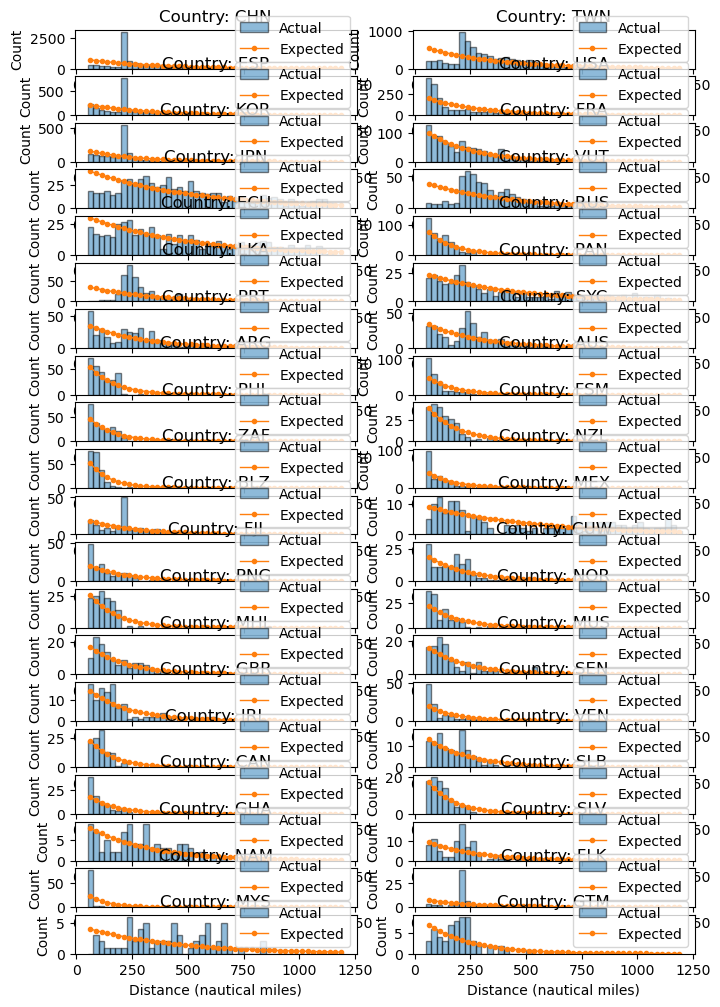

In [38]:
# new df for visualizations on Power BI
spike_viz_structured = pd.DataFrame(columns=['flag', 'Bin', 'Actual_Count', 'Expected_Count'])

fig, axes = plt.subplots(round(num_countries/2), 2, figsize=(8, 12))

# Flatten the axes for easy looping
axes = axes.flatten()

# Loop over top countries
for i, country in enumerate(top_countries):
    ax = axes[i]
    
    # Your data for one country (Replace this with your actual data)
    data = ais_spike[ais_spike['flag'] == country]['gap_start_distance_from_shore_nmi'].to_numpy()

    # Create custom bins
    bin_width = 25
    min_bin = 50
    max_bin = 1200
    custom_bins = np.arange(min_bin, max_bin + bin_width, bin_width)

    # Calculate bin centers
    bin_centers = (custom_bins[:-1] + custom_bins[1:]) / 2

    # Actual count of ships in each bin
    hist, _ = np.histogram(data, bins=custom_bins)
    
    # Estimate the rate parameter (lambda)
    lambda_estimate = 1 / np.mean(data)

    # Generate the expected distribution for a range of distances
    cdf_values = 1 - np.exp(-lambda_estimate * custom_bins)  
    expected_frequency = np.diff(cdf_values) * len(data)
    
    # Normalize expected_frequency so that the sum of observed and expected frequencies match
    sum_hist = np.sum(hist)
    sum_expected_frequency = np.sum(expected_frequency)
    normalization_factor = sum_hist / sum_expected_frequency
    expected_frequency_normalized = expected_frequency * normalization_factor
    
    # Add the data to the structured_data DataFrame
    for i, bin_center in enumerate(bin_centers):
        spike_viz_structured = spike_viz_structured.append({
            'flag': country,
            'Bin': bin_center,
            'Actual_Count': hist[i],
            'Expected_Count': expected_frequency_normalized[i]
        }, ignore_index=True)

    # Plot the actual counts as a histogram
    ax.hist(custom_bins[:-1], custom_bins, weights=hist, alpha=0.5, label='Actual', edgecolor='black')

    # Plot the expected frequencies as a line with markers
    ax.plot(bin_centers, expected_frequency_normalized, marker='.', linestyle='-', linewidth=1, label='Expected')

    # Add labels and legend
    ax.set_xlabel('Distance (nautical miles)')
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title(f'Country: {country}')

# Remove any unused subplots
for i in range(len(top_countries), len(axes)):
    axes[i].axis('off')

# Show the grid of plots
plt.tight_layout()
plt.show()

In [39]:
# merge 'SOVEREIGNT' from countries_border to spike_viz_structured, join on 'flag'
spike_viz_structured = pd.merge(spike_viz_structured, countries_border[['SOVEREIGNT', 'ADM0_A3']], how='left', left_on='flag', right_on='ADM0_A3')
# drop 'ADM0_A3' col
spike_viz_structured = spike_viz_structured.drop(columns=['ADM0_A3'])
spike_viz_structured


,flag,Bin,Actual_Count,Expected_Count,SOVEREIGNT
0,CHN,62.5,256,708.503377,China
1,CHN,87.5,252,651.024230,China
2,CHN,112.5,231,598.208226,China
3,CHN,137.5,197,549.677055,China
4,CHN,162.5,157,505.083099,China
...,...,...,...,...,...
1835,GTM,1087.5,0,0.042959,Guatemala
1836,GTM,1112.5,0,0.037936,Guatemala
1837,GTM,1137.5,0,0.033499,Guatemala
1838,GTM,1162.5,0,0.029582,Guatemala


In [42]:
spike_viz_structured.to_csv('spike_visualization.csv', index=False)

### past drafts

##### histogram expected vs actual

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# data = ais_spike[ais_spike['flag'] == 'FSM']['gap_start_distance_from_shore_nmi'].to_numpy()

# # Create custom bins
# bin_width = 25
# min_bin = 50
# max_bin = 1200
# custom_bins = np.arange(min_bin, max_bin + bin_width, bin_width)

# # Calculate bin centers
# bin_centers = (custom_bins[:-1] + custom_bins[1:]) / 2

# # Estimate the rate parameter (lambda)
# lambda_estimate = 1 / np.mean(data)

# # Generate the expected distribution for a range of distances
# cdf_values = 1 - np.exp(-lambda_estimate * custom_bins)  # CDF of the exponential distribution
# expected_frequency = np.diff(cdf_values) * len(data)  # Differences between consecutive CDF values

# # Actual count of ships in each bin
# hist, _ = np.histogram(data, bins=custom_bins)

# # Create the plot
# fig, ax = plt.subplots()

# # Plot the actual counts as a histogram
# ax.hist(custom_bins[:-1], custom_bins, weights=hist, alpha=0.5, label='Actual Count', edgecolor='black')

# # Plot the expected frequencies as a line with markers
# ax.plot(bin_centers, expected_frequency, marker='o', linestyle='-', linewidth=2, label='Expected Count')

# # Add labels and legend
# ax.set_xlabel('Distance (nautical miles)')
# ax.set_ylabel('Count')
# ax.legend()

# # Show the plot
# plt.show()


##### Sun duration calculation code

In [ ]:
# ### Verification - sunlist is empty
# gapid = 'd3194da46490a3df870201a547ab82cd'
# df_no_sun_event = df_no_sun_event[df_no_sun_event['gap_id'] == gapid]
# df_no_sun_event['daytime_duration'], df_no_sun_event['nighttime_duration'] = zip(*df_no_sun_event.apply(calculate_day_night_duration, axis=1))

# # df_no_sun_event = df_no_sun_event[df_no_sun_event['start_timezone'] == 'Etc/GMT']

# df_no_sun_event.head().T

# ### Verification
# temp_gmt = df_suntime[df_suntime['start_timezone'] == 'Etc/GMT']
# temp_gmt = temp_gmt
# # temp_gmt.head().T

# temp_gmt_polar = df_suntime[df_suntime['sun_times'].apply(lambda x: any([entry[0] == 'polar_phenomenon' for entry in x]) & (len(x) != 1))]
# temp_gmt_polar.head(10).T
# gapid = 'e062761dbf152c31b781fc0e8854a45a'
# temp_list = df_suntime[df_suntime['gap_id'] == gapid]['sun_times'].tolist()
# print(temp_list)
# df_suntime[df_suntime['gap_id'] == gapid].T
# temp = df_suntime[df_suntime['gap_id'] == gapid]['sun_times'].tolist()
# temp = temp[0]

# df_timestamps = pd.DataFrame(columns=['timestamp', 'event'])
# # insert first row, which is '2018-05-21 09:43:56+00:00', 'start'
# df_timestamps = df_timestamps.append({'timestamp': df_suntime[df_suntime['gap_id'] == gapid]['gap_start_timestamp'].tolist()[0], 'event': 'start'}, ignore_index=True)

# for entry in temp:
#     df_timestamps = df_timestamps.append({'timestamp': entry[1], 'event': entry[0]}, ignore_index=True)

# df_timestamps = df_timestamps.append({'timestamp': df_suntime[df_suntime['gap_id'] == gapid]['gap_end_timestamp'].tolist()[0], 'event': 'end'}, ignore_index=True)

# # pop row where event is 'polar_phenomenon'
# df_timestamps = df_timestamps[df_timestamps['event'] != 'polar_phenomenon']
# # set timestamp col as datetime
# df_timestamps['timestamp'] = pd.to_datetime(df_timestamps['timestamp'])
# # sort by timestamp col, ascending
# df_timestamps = df_timestamps.sort_values(by=['timestamp'], ascending=True)
# df_timestamps

# # create new col that is the time difference between each row
# df_timestamps['time_diff'] = df_timestamps['timestamp'].diff()
# df_timestamps

# df_timestamps = pd.DataFrame()


# # Loop through each row to unpack the list of tuples
# for i, row in df_suntime.iterrows():
#     temp_dict = {}
#     for entry in row['sun_times']:
#         label, timestamp = entry
#         # Assuming you want to overwrite if multiple instances of the same label are found.
#         # Modify this part if you want to handle them differently.
#         temp_dict[label] = timestamp
#     df_timestamps = df_timestamps.append(temp_dict, ignore_index=True)

# df_timestamps

In [ ]:
# ##### Get day vs night duration for entries WITHOUT sun event
# from astral.sun import sun
# from astral import LocationInfo
# import pandas as pd

# # Define function to get sunrise and sunset times for the date of start and end timestamp. 
# def get_sun_times(row):
#     # Initialize polar phenomena variables
#     polar_start = None
#     polar_end = None

#     # For start location
#     loc_start = LocationInfo("", "", "", row['gap_start_lat'], row['gap_start_lon'])
#     try:
#         s_start = sun(loc_start.observer, date=row['gap_start_timestamp'].date())
#         sunrise_start, sunset_start = s_start['sunrise'], s_start['sunset']
#     except Exception as e:
#         sunrise_start, sunset_start = pd.NaT, pd.NaT
#         if "Sun never reaches" in str(e):
#             polar_start = 'Polar Day'
#         elif "Sun is always below" in str(e):
#             polar_start = 'Polar Night'
#         else:
#             # print(f"Start Error for row {row.name}: {e}")
#             polar_start = 'Error'

#     # For end location
#     loc_end = LocationInfo("", "", "", row['gap_end_lat'], row['gap_end_lon'])
#     try:
#         s_end = sun(loc_end.observer, date=row['gap_end_timestamp'].date())
#         sunrise_end, sunset_end = s_end['sunrise'], s_end['sunset']
#     except Exception as e:
#         sunrise_end, sunset_end = pd.NaT, pd.NaT
#         if "Sun never reaches" in str(e):
#             polar_end = 'Polar Day'
#         elif "Sun is always below" in str(e):
#             polar_end = 'Polar Night'
#         else:
#             # print(f"End Error for row {row.name}: {e}")
#             polar_end = 'Error'

#     # Return calculated values
#     return pd.Series([sunrise_start, sunset_start, polar_start, sunrise_end, sunset_end, polar_end])

# # Apply the function and create new columns
# df_prep[['start_sunrise', 'start_sunset', 'start_polar_phenomenon', 
#                 'end_sunrise', 'end_sunset', 'end_polar_phenomenon']] = df_prep.apply(get_sun_times, axis=1)

# def calculate_day_night_duration(row):
#     print(row['gap_id'])
#     start_time = row['gap_start_timestamp']
#     end_time = row['gap_end_timestamp']

#     # Initialize total daylight and nighttime durations
#     total_daylight = pd.Timedelta(0)
#     total_night = pd.Timedelta(0)

#     current_date = start_time.date()

#     while current_date <= end_time.date():
#         print(current_date)
#         # Determine whether to use start or end location's sun times for the current day
#         days_from_start = (current_date - start_time.date()).days
#         days_from_end = (end_time.date() - current_date).days
        
#         if days_from_start <= days_from_end or current_date == start_time.date():
#             sunrise, sunset, polar_phenom = row['start_sunrise'], row['start_sunset'], row['start_polar_phenomenon']
#         else:
#             sunrise, sunset, polar_phenom = row['end_sunrise'], row['end_sunset'], row['end_polar_phenomenon']

#         # Handle polar phenomena
#         if polar_phenom == 'Polar Day':
#             total_daylight += min(pd.Timedelta(days=1), end_time - start_time) if current_date != end_time.date() else end_time - start_time
#         elif polar_phenom == 'Polar Night':
#             total_night += min(pd.Timedelta(days=1), end_time - start_time) if current_date != end_time.date() else end_time - start_time
#         else:
#             # Handle normal days with sunrise and sunset

#             # Day duration for the current day
#             day_start = max(sunrise, start_time)
#             day_end = min(sunset, end_time)

#             # Night duration for the current day
#             night_start = max(start_time, sunset)
#             night_end = min(end_time, sunrise + pd.Timedelta(days=1))
            
#             # Account for the first day where the gap might start before sunrise
#             if current_date == start_time.date() and start_time < sunrise:
#                 total_night += sunrise - start_time

#             # Accumulate total daylight and nighttime
#             total_daylight += max((day_end - day_start), pd.Timedelta(0))
#             total_night += max((night_end - night_start), pd.Timedelta(0))
        
#         # Move to the next day
#         current_date += pd.Timedelta(days=1)

#     return pd.Series([total_daylight.total_seconds() / 3600, total_night.total_seconds() / 3600])

# # Apply the function to the dataframe
# df_prep = df_prep.iloc[70:75, :]
# df_prep[['daytime_hours', 'nighttime_hours']] = df_prep.apply(calculate_day_night_duration, axis=1)

# df_prep[df_prep['start_timezone'] == 'Etc/GMT']
# # df_prep[df_prep['gap_id'] == 'aa865f44d5f76c905e56ffcf769d8c43'].T
# df_prep.iloc[0, :].T

##### other

In [ ]:
# countries_border = countries_border_raw.copy()

# # filter the country borders GeoDataFrame to only include the specified countries
# selected_countries = countries_border[countries_border['ADM0_A3'].isin(['ESP'])]

# # Plot the selected countries
# fig, ax = plt.subplots(figsize=(15, 15))
# selected_countries.plot(ax=ax, edgecolor='black', color='lightgray', linewidth=1.5)

# # Set title and labels
# ax.set_title("Visualization of Countries")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")

# plt.show()


In [ ]:
# def num_points(geom):
#     if geom.geom_type == 'Polygon':
#         # Sum of exterior and all interior ring points
#         return len(geom.exterior.coords) + sum(len(interior.coords) for interior in geom.interiors)
#     elif geom.geom_type == 'MultiPolygon':
#         # Recursively compute for each polygon and sum up
#         return sum(num_points(polygon) for polygon in geom.geoms)
#     else:
#         return 0

# selected_countries['num_points'] = selected_countries['geometry'].apply(num_points)
# selected_countries[['SOVEREIGNT', 'num_points']]

In [ ]:
# tolerance = 0.1
# selected_countries_dpsimp = selected_countries.copy()
# selected_countries_dpsimp['geometry'] = selected_countries_dpsimp['geometry'].simplify(tolerance, preserve_topology=True)

# # Plot the selected countries
# fig, ax = plt.subplots(figsize=(15, 15))
# selected_countries_dpsimp.plot(ax=ax, edgecolor='black', color='lightgray', linewidth=1.5)

# # Set title and labels
# ax.set_title("Visualization of Countries")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")

# plt.show()


In [ ]:
# selected_countries_dpsimp['num_points'] = selected_countries_dpsimp['geometry'].apply(num_points)
# selected_countries_dpsimp[['SOVEREIGNT', 'num_points']]

In [ ]:
# # Convert the AIS dataframe to a GeoDataFrame
# geometry = [Point(xy) for xy in zip(ais_data.gap_start_lon, ais_data.gap_start_lat)]
# ais_geo = GeoDataFrame(ais_data, geometry=geometry)

# ais_geo.head()
